# Segment and quantify puncta in individual cells (Setup)

Detect and segment puncta and analyze their size and intensity. Calculate puncta statistics per cell nucleus.

Run this notebook cell-by-cell and follow the instructions.

## Requirements
- A folder with images that should be analyzed.  All z-layers for a specific sample must be combined into a single file. To combine z-layers and channels, run [run_images_to_stack.ipynb](run_images_to_stack.ipynb). To compute puncta statistics per cell, cell segmentation should be provided as an additional channel. To segment cells/nuclei, run [run_cell_segmentation.ipynb](run_cell_segmentation.ipynb).


<hr style="height:2px;">

## Config

<hr style="height:2px;">

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import json
import os
import numpy as np
import intake_io
from skimage.feature import blob_log
from skimage.segmentation import watershed
from scipy import ndimage
import pylab as plt

from am_utils.utils import walk_dir
from punctatools.lib.segment import calculate_background_image, centers_to_markers, threshold_puncta
from punctatools.lib.utils import show_dataset, show_imgs, display_blobs
from punctatools.lib.utils import crop_dataset, load_parameters, save_parameters, convert_params

%matplotlib inline

2022-01-25 16:04:49,893 [INFO] WRITING LOG OUTPUT TO /home/amedyukh/.cellpose/run.log



<hr style="height:2px;">

## Set up the data to segment

<hr style="height:2px;">

### Please provide data paths:

#### Option 1 (preferred)

`parameter_file`: parameter file (json) with previously set up parameters (e.g. with [setup_cell_segmentation.ipynb](setup_cell_segmentation.ipynb))

`output_dir`: output directory for the puncta analysis results

<hr style="height:0.5px;">

#### Option 2

`input_dir`: folder with input images; if the cell/nuclei segmentation was done this should be the output of the cell/nuclei segmentation. To segment cells/nuclei, run [run_cell_segmentation.ipynb](run_cell_segmentation.ipynb).

`cell_segmentation`: Set to `True` if the cell/nuclei segmentation was performed. Otherwise set to `False`. Default if `False`

`output_dir`: output directory for the puncta analysis results

In [2]:
parameter_file = 'parameters.json'
output_dir = "../test_output/puncta_analysis"

# input_dir = "../test_output/cells"
# cell_segmentation = False
# output_dir = "../test_output/puncta_analysis"

### The following code lists all image files in the input directory:

In [3]:
#################################
#  Don't modify the code below  #
#################################

if 'parameter_file' in vars():
    with open(parameter_file) as f:
        params = json.load(f)

    if 'roi_segmentation_dir' in params:
        input_dir = params['roi_segmentation_dir']
        roi_segmentation = True
    else:
        input_dir = params['converted_data_dir']
        roi_segmentation = False
        
elif not ('input_dir' in vars() and 'roi_segmentation' in vars()):
    raise ValueError('Values of either "parameter_file" or "input_dir" and'\
                     '"cell_segmentation" must be provided')

    
print(rf"Input directory: {input_dir}")
if not roi_segmentation:
    print('No cell segmentation provided')
samples = walk_dir(input_dir)

print(f'\n{len(samples)} images were found:')
for i in range(len(samples)):
    print(i, samples[i])

Input directory: /tmp/pycharm_project_989/test_output/roi

2 images were found:
0 /tmp/pycharm_project_989/test_output/roi/sample1_position1.tif
1 /tmp/pycharm_project_989/test_output/roi/sample1_position2.tif


### Please provide the index of the sample to analyze:

Set to `None` to select a random image

In [4]:
sample_index = 0

### The following code loads a random image

In [5]:
#################################
#  Don't modify the code below  #
#################################

if sample_index is None:
    sample_index = np.random.randint(len(samples))
    
sample = samples[sample_index]
dataset = intake_io.imload(sample)
print(dataset, '\n')
nchannels = len(dataset['c'].data)
if roi_segmentation:
    nchannels -= 1
print(rf"Number of channels: {nchannels}")

<xarray.Dataset>
Dimensions:  (y: 326, x: 326, z: 5, c: 4)
Coordinates:
  * y        (y) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * x        (x) float64 0.0 0.11 0.22 0.33 0.44 ... 35.42 35.53 35.64 35.75
  * z        (z) float64 0.0 0.2 0.4 0.6 0.8
Dimensions without coordinates: c
Data variables:
    image    (c, z, y, x) uint16 111 114 120 143 172 158 148 ... 0 0 0 0 0 0 0
Attributes:
    metadata:  {'spacing_units': {}} 

Number of channels: 3


### Please specify the indices of puncta channels and the channel to set up

The indices start from 0. 

`puncta_channels`: list of channel indices, starting form 0, where puncta should be detected.

In [6]:
puncta_channels = [1, 2]

### The following code displays the puncta channels and the nuclei segmentation of the current image

Current number of z layers: 5


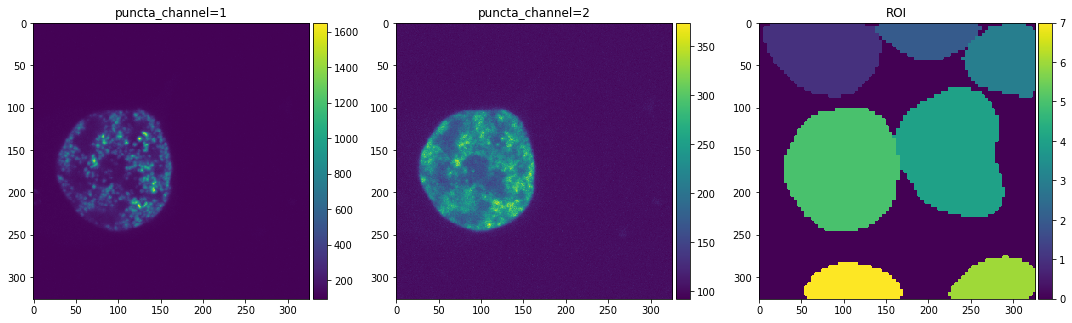

In [7]:
#################################
#  Don't modify the code below  #
#################################

if 'z' in dataset.dims:
    print(rf'Current number of z layers: {len(dataset["z"].data)}')
else:
    print('No z layers were found, the dataset is 2D')
    
channel_names = [rf"puncta_channel={i}" for i in puncta_channels]
    
if roi_segmentation:
    show_dataset(dataset, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(dataset, puncta_channels, channel_names)
    

### Please select a small box to test the analysis:

Keep the width and height 200 - 500 pixels.

To used the entire image, set x, y, z, width, height and depth to `None`

In [8]:
x = 0    # coordinate of the left border
y = 70   # coordinate of the top border
z = 0
width = 200   # width of the box
height = 200  # height of the box
depth = 5

### The following code crops the dataset and displays the cropped area:

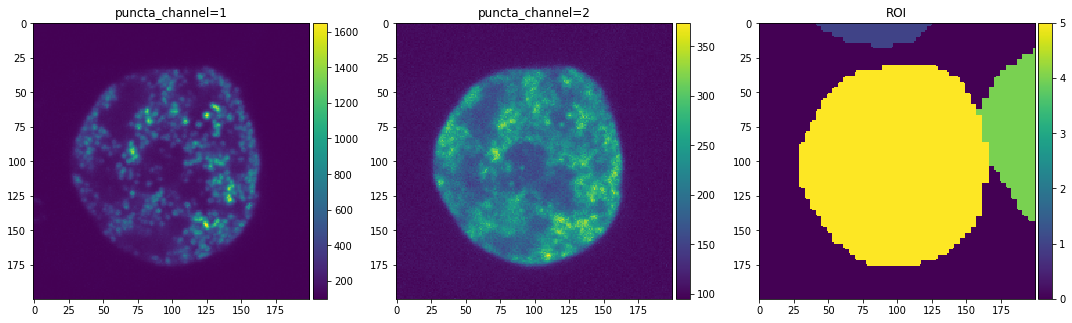

In [9]:
#################################
#  Don't modify the code below  #
#################################

ds_crop = crop_dataset(dataset, x, y, z, width, height, depth)

if roi_segmentation:
    show_dataset(ds_crop, puncta_channels + [-1], channel_names + ['ROI'])
else:
    show_dataset(ds_crop, puncta_channels, channel_names)


<hr style="height:2px;">

## Set up puncta detection

<hr style="height:2px;">

The following are the steps to set up puncta detection. At each step, you will be asked to set up the corresponding parameters.

1. Detect puncta centers
2. Filter out centers based on their intensity relative to the background. 
3. Segment puncta masks from the background
4. Remove large puncta and puncta outside cells/nuclei


### Please specify parameters for detection of puncta centers

You can specify one value or a list for each parameter. If one value is provided, the same value will be used for all channels. Provide a list if different values should be used for different puncta channels. The length of the list should be equal to the number of puncta channels.

#### Frequent:

`minsize_um`: minimal sigma for the Laplacian of Gaussian detection (microns); default is 0.2

`maxsize_um`: maximal sigma for the Laplacian of Gaussian detection (microns); default is 2

`threshold_detection`: threshold for detecting LoG blobs. The absolute lower bound for scale space maxima. Local maxima smaller than thresh are ignored. Reduce this to detect blobs with less intensities. Should be close to 0 and can be both positive and negative.

#### Advanced:

`num_sigma`: number of sigma values for the Laplacian of Gaussian detection; default is 5

`overlap`: a value between 0 and 1; if two blobs overlaps by a fraction greater than this value, the smaller blob is eliminated; default is 1 (blobs are removed only if overlapping completely)

<hr style="height:0.5px;">

If you are having trouble detecting puncta, start with very low value of `threshold_detection` (e.g. 0), and adjust `minsize_um` and `maxsize_um` to make sure that all puncta of relevant size are detected. After that, increase the value of `threshold_detection` to remove dim puncta.


In [10]:
# frequent:
minsize_um = 0.2  
maxsize_um = 2  
threshold_detection = [0.001, 0.0001] 

# advanced:
num_sigma = 5
overlap = 1

### The following code detects puncta centers and shows results

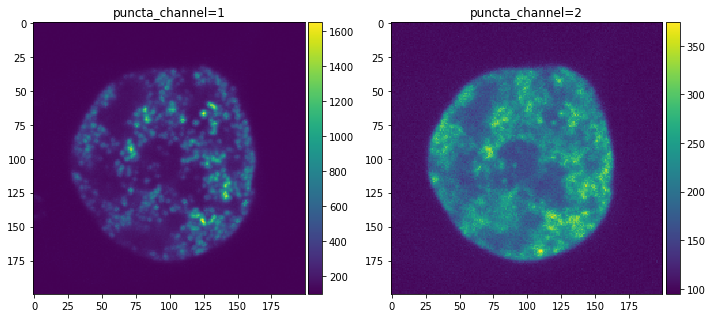

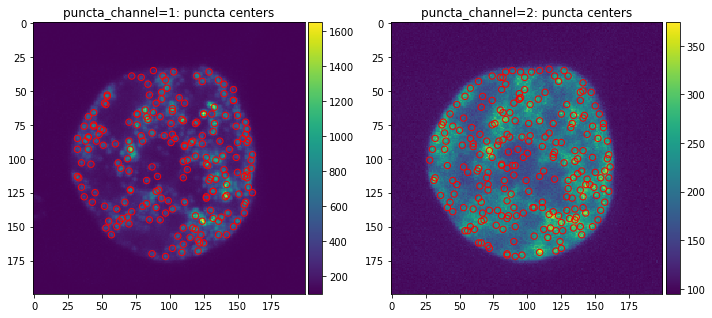

In [11]:
#################################
#  Don't modify the code below  #
#################################

spacing = np.array(intake_io.get_spacing(dataset))
chnames = ds_crop['c'].data
imgs = []

logblobs_all = []
for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    minsize_um2, maxsize_um2, threshold_detection2, num_sigma2, overlap2 = convert_params(len(puncta_channels), 
                                                                                          i,
                                                                                          minsize_um, maxsize_um, 
                                                                                          threshold_detection, 
                                                                                          num_sigma, overlap)
    img = ds_crop.loc[dict(c=chnames[current_channel])]['image'].data
    imgs.append(img)

    # find blob centers with scale-adapted LoG
    logblobs = blob_log(img,
                        min_sigma=minsize_um2 / spacing,
                        max_sigma=maxsize_um2 / spacing,
                        num_sigma=int(num_sigma2),
                        overlap=overlap2,
                        threshold=threshold_detection2)
    logblobs_all.append(logblobs)

show_dataset(ds_crop, puncta_channels, channel_names)
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)] for logblobs in logblobs_all], 
              puncta_channels, channel_names, 'puncta centers')

### Please specify parameters for background filtering

You can specify one value or a list for each parameter. If one value is provided, the same value will be used for all channels. Provide a list if different values should be used for different puncta channels. The length of the list should be equal to the number of puncta channels.

#### Frequent:

`threshold_background`: threshold used to post-filter puncta in cells with diffuse signal. This threshold is provided relative to the median GFP intensity inside cells (e.g, `threshold_background` = 2 will result in all puncta with intensity lower than two median GPF (background) intensities being removed). Set to 0 to keep all puncta.

`global_background`: If True, the background value is calculated globally as the `global_background_percentile` of all cells.(Default is True)


#### Advanced:

`background_percentile`: Percentile (between 0 and 100) of image intensity inside cell to calculate the background value. (Default is 50 (median)).

`global_background_percentile`: Percentile (between 0 and 100) of cell background values to calculate the global background value. (Default is 95).


In [12]:
# frequent:
threshold_background = [3, 1.5]
global_background = False

# advanced:
background_percentile = 50
global_background_percentile = 95

### The following code filters puncta centers based on their intensity relative to the background

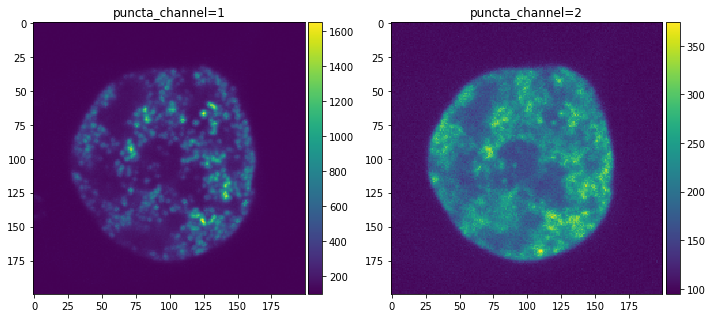

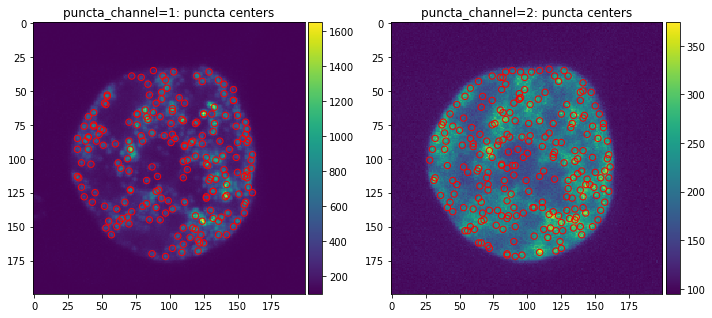

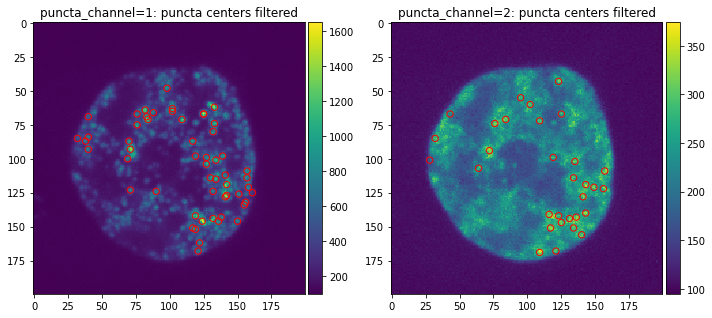

In [13]:
#################################
#  Don't modify the code below  #
#################################


roi = ds_crop.loc[dict(c=chnames[-1])]['image'].data
bg_imgs = []
new_centers = []
markers_all = []

for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    
    threshold_background2, global_background2, \
    background_percentile2, global_background_percentile2 = convert_params(len(puncta_channels), i,
                                                                          threshold_background, 
                                                                          global_background, 
                                                                          background_percentile, 
                                                                          global_background_percentile)

    # calculate background image
    bg_img = calculate_background_image(imgs[i], roi, global_background2,
                                        global_background_percentile2, background_percentile2)
    bg_imgs.append(bg_img)

    # convert the blob centers to watershed markers, filter by background
    markers = centers_to_markers(logblobs_all[i], imgs[i], bg_img, threshold_background2)
    markers_all.append(markers)

    # find blob centers with scale-adapted LoG
    new_centers.append(np.array(ndimage.center_of_mass(markers, markers, np.unique(markers)[1:])))

show_dataset(ds_crop, puncta_channels, channel_names)
display_blobs(ds_crop, [logblobs[:, :int(logblobs.shape[1]/2)] for logblobs in logblobs_all], 
              puncta_channels, channel_names, 'puncta centers')
display_blobs(ds_crop, new_centers, puncta_channels, channel_names, 'puncta centers filtered')


### Please specify parameters for puncta segmentation 

You can specify one value or a list for each parameter. If one value is provided, the same value will be used for all channels. Provide a list if different values should be used for different puncta channels. The length of the list should be equal to the number of puncta channels.

`threshold_segmentation`: Threshold for puncta segmentation. The way the threshold is applied is determined by `segmentation_mode`. For mode 0, choose values in the order of 0.001; for mode 1, choose values in the order of 50; for mode 2, choose values in the order of 3. Reduce to detect more/larger puncta, increase to detect fewer/smaller puncta

`segmentation_mode`: 0, 1, or 2. Determines the mode how `threshold_segmentation` is applied; 0: apply absolute threshold in LoG space; 1: apply threshold relative to background in LoG space; 2: apply threshold relative to the background in image intensity space.


In [14]:
threshold_segmentation = [0.001, 0.0005]
segmentation_mode = 0

### The following code segments pucnta

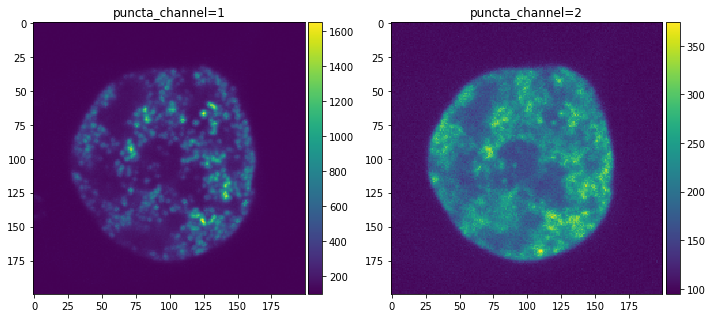

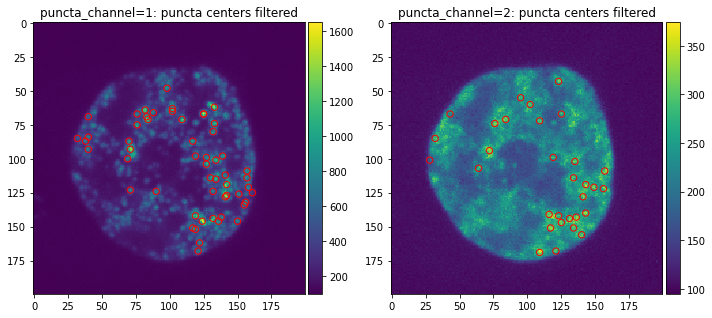

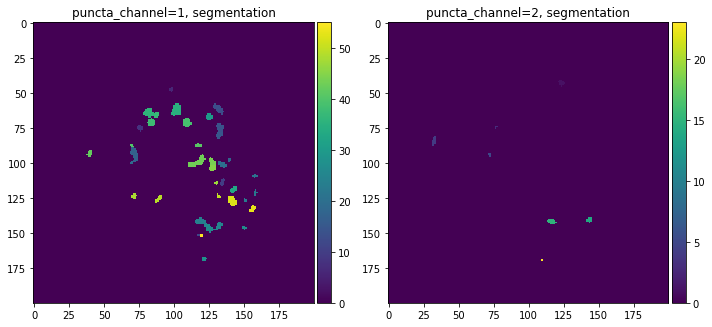

In [15]:
#################################
#  Don't modify the code below  #
#################################

puncta_prelim = []
masks = []

for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    threshold_segmentation2, segmentation_mode2 = convert_params(len(puncta_channels), i,
                                                                 threshold_segmentation, segmentation_mode)

    mask = threshold_puncta(imgs[i], bg_imgs[i], roi, minsize_um2, maxsize_um2, num_sigma2, spacing,
                                segmentation_mode2, threshold_segmentation2)
    masks.append(mask)
    dist = ndimage.distance_transform_edt(mask, sampling=tuple(spacing))
    puncta_prelim.append(watershed(-dist, markers_all[i], mask=mask))

    
show_dataset(ds_crop, puncta_channels, channel_names)
display_blobs(ds_crop, new_centers, puncta_channels, channel_names, 'puncta centers filtered')
show_imgs(puncta_prelim, [chname + ', segmentation' for chname in channel_names])

### Please specify parameters for puncta postprocessing 

`remove_out_of_roi`: If True, remove all puncta (parts) that are not inside cells/nuclei.

`maxrad_um`: If not None, remove puncta with a radius larger than this value. Set to None to keep all detected puncta.


In [16]:
remove_out_of_roi = False
maxrad_um = None

### The following code removes large puncta and puncta (parts) that are out of cells

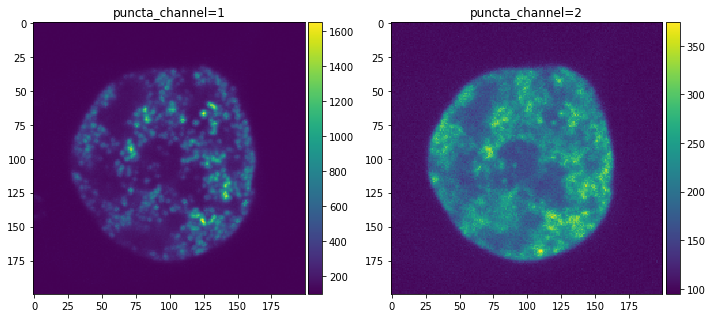

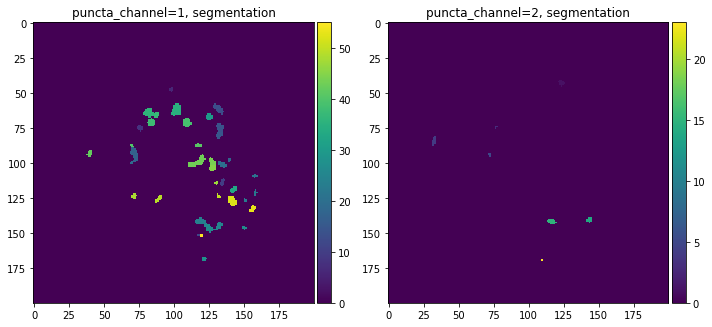

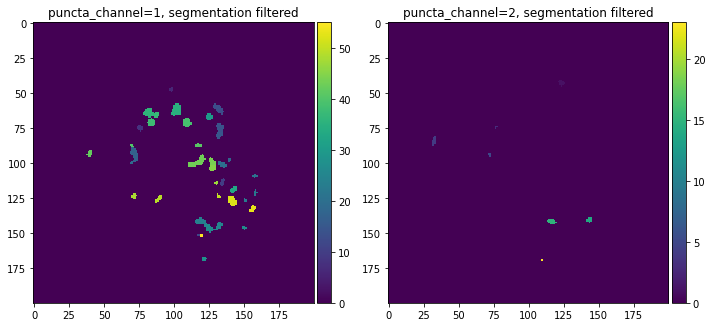

In [17]:
#################################
#  Don't modify the code below  #
#################################

puncta_all = []

for i in range(len(puncta_channels)):
    current_channel = puncta_channels[i]
    
    remove_out_of_roi2, maxrad_um2  = convert_params(len(puncta_channels), i,
                                                      remove_out_of_roi, maxrad_um)
    puncta = masks[i].copy()
    
    if remove_out_of_roi2 and roi is not None:
        puncta = puncta * (roi > 0)


    dist = ndimage.distance_transform_edt(puncta, sampling=tuple(spacing))
    puncta = watershed(-dist, markers_all[i], mask=puncta)
    if maxrad_um is not None:
        llist = np.unique(puncta)
        vol = ndimage.sum(puncta > 0, puncta, llist) * np.prod(spacing)
        maxvol = 4. / 3 * np.pi * maxrad_um2 ** 3
        ix = np.in1d(puncta.ravel(), llist[vol > maxvol]).reshape(puncta.shape)
        puncta[ix] = 0
    puncta_all.append(puncta)

show_dataset(ds_crop, puncta_channels, channel_names)
show_imgs(puncta_prelim, [chname + ', segmentation' for chname in channel_names])
show_imgs(puncta_all, [chname + ', segmentation filtered' for chname in channel_names])

<hr style="height:2px;">

## Run the full processing

The parameters set up in this notebook will be used to segment images in batch.

<hr style="height:2px;">

### The following code checks if the parameter file name was provided

In [18]:
#################################
#  Don't modify the code below  #
#################################

if 'parameter_file' in vars():
    print(rf"The current parameter file name is '{parameter_file}'; "\
          "you can leave the 'parameter_file' variable commented")
else:
    print("No parameter file was provided; please provide the parameter file name")

The current parameter file name is 'parameters.json'; you can leave the 'parameter_file' variable commented


In [19]:
parameter_file = 'parameters.json'

### Please specify the number of processes to run in parallel


`n_jobs`: number of processes to run in parallel. Set according to your workstation resources. Decrease if it runs out of memory. (Default is 8)

In [20]:
n_jobs=8

### Please specify the list of channel names 

In [21]:
channel_names = ['ch0', 'ch1', 'ch3']

### The following code checks the validity of the list of channels

In [22]:
#################################
#  Don't modify the code below  #
#################################

nchannels = len(dataset['c'].data)
if roi_segmentation:
    nchannels -= 1

if len(channel_names) == nchannels:
    print("The list of channel names is valid")
else:
    print(rf"The dataset contains {nchannels} channel, but {len(channel_names)} names were provided. "\
          rf"Please provide {nchannels} names")

The list of channel names is valid


### Please specify the names for the puncta analysis outputs

`puncta_segm_dir`: subdirectory to store segmented puncta masks (added as extra channel(s) to the input data)

`puncta_quant_dir`: subdirectory to store measurements for individual puncta

`roi_quant_dir`: subdirectory to store measurements for individual ROI (nuclei, cells)

In [23]:
puncta_segm_dir = 'puncta_segm'
puncta_quant_dir = 'puncta_quants'
roi_quant_dir = 'cell_quants'

### The following code saves the parameters

To run the full processing, run the notebook [run_puncta_analysis.ipynb](run_puncta_analysis.ipynb) with the parameter values identified here.

In [24]:
#################################
#  Don't modify the code below  #
#################################

params = dict(
    puncta_analysis_dir=os.path.realpath(output_dir),
    puncta_segm_dir=puncta_segm_dir,
    puncta_quant_dir=puncta_quant_dir,
    roi_quant_dir=roi_quant_dir,
    puncta_channels=puncta_channels,
    roi_segmentation=roi_segmentation,
    minsize_um=minsize_um,
    maxsize_um=maxsize_um,
    num_sigma=num_sigma,
    overlap=overlap,
    threshold_detection=threshold_detection,
    threshold_background=threshold_background,
    global_background=global_background,
    global_background_percentile=global_background_percentile,
    background_percentile=background_percentile,
    threshold_segmentation=threshold_segmentation,
    segmentation_mode=segmentation_mode,
    remove_out_of_roi=remove_out_of_roi,
    maxrad_um=maxrad_um,
    n_jobs=n_jobs,
    channel_names=channel_names
)

if roi_segmentation:
    params['roi_segmentation_dir'] = os.path.realpath(input_dir)
else:
    params['converted_data_dir'] = os.path.realpath(input_dir)

params = save_parameters(params, parameter_file)
    
params

{'converted_data_dir': '/tmp/pycharm_project_989/example_data/stacks',
 'roi_segmentation_dir': '/tmp/pycharm_project_989/test_output/roi',
 'roi_channel': 0,
 'diameter': 120,
 'model_type': 'cyto',
 'do_3D': False,
 'remove_small_mode': '2D',
 'remove_small_diam_fraction': 0.5,
 'flow_threshold': 0.4,
 'cellprob_threshold': 0,
 'gpu': True,
 'puncta_analysis_dir': '/tmp/pycharm_project_989/test_output/puncta_analysis',
 'puncta_segm_dir': 'puncta_segm',
 'puncta_quant_dir': 'puncta_quants',
 'roi_quant_dir': 'cell_quants',
 'puncta_channels': [1, 2],
 'roi_segmentation': True,
 'minsize_um': 0.2,
 'maxsize_um': 2,
 'num_sigma': 5,
 'overlap': 1,
 'threshold_detection': [0.001, 0.0001],
 'threshold_background': [3, 1.5],
 'global_background': False,
 'global_background_percentile': 95,
 'background_percentile': 50,
 'threshold_segmentation': [0.001, 0.0005],
 'segmentation_mode': 0,
 'remove_out_of_roi': False,
 'maxrad_um': None,
 'n_jobs': 8,
 'channel_names': ['ch0', 'ch1', 'ch3']}